Import packages

In [2]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.Optimization import SavantPSO
import numpy as np

# Read in

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/config ups mx.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']
optimization_start_date = config_dict['PROPHETSETTING']['optimization_start_date']
optimization_end_date = config_dict['PROPHETSETTING']['optimization_end_date']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

# Read Data

In [4]:
bdDf = pd.read_csv(base_path+'New_Cuts_df.csv',index_col = False) # read the new_cuts_df.csv file 
cuts_df = bdDf
cuts_df = cuts_df[cuts_df['funnel'] != 'Non_Brand']
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_exclude,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month
0,Mexico,-,Brand,183,0.5,1.0,10.0,multiplicative,additive,multiplicative,...,na,na,multiplicative,na,na,na,na,linear,251.0,2024-04-25


In [5]:
# create a variable with the name of the pickle file
if 'market' in cuts_df.columns and 'account_type' in cuts_df.columns and 'funnel' in cuts_df.columns:
    cuts_df['forecaster_name_list'] = cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl'
    cuts_df['periods'] = periods  # create the variable with the number of periods to forecast
else:
    missing_columns = [col for col in ['market', 'account_type', 'funnel'] if col not in cuts_df.columns]
    print(f"Error: missin_columns: {missing_columns}")

/var/tmp/ipykernel_4979/4208556210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cuts_df['forecaster_name_list'] = cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl'
/var/tmp/ipykernel_4979/4208556210.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cuts_df['periods'] = periods  # create the variable with the number of periods to forecast


In [6]:
# get model list
forecasters_array = cuts_df.forecaster_name_list
forecasters_array

0    Mexico - Brand.pkl
Name: forecaster_name_list, dtype: object

In [7]:
# Get analytical file
analytical_file = pd.read_csv(analytical_file_path)# read the analytical file .csv 
analytical_file['ds'] = pd.to_datetime(analytical_file['ds']) # ensure the date variable is in the correct datetime type
analytical_file_check_version = analytical_file.copy() # generate a copy 
analytical_file_check_version = analytical_file_check_version[analytical_file_check_version['funnel'] != 'Non_Brand']
analytical_file_check_version.funnel.unique()

array(['Brand'], dtype=object)

In [8]:
# Get constrain file
constraint_file = pd.read_csv(constraint_file_name) # read the constraint file .csv
constraint_file['init'] = constraint_file[['MinWeight', 'MaxWeight']].mean(axis = 1) #create a variable with the initial weights the mean between the min weight and the max weight
constraint_file = constraint_file[constraint_file['funnel'] != 'Non_Brand']
constraint_file.tail()

,market,account_type,funnel,Month,Year,variable_splits,Constrain_Variable_Name,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,...,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,MinWeight,MaxWeight,init
8,Mexico,-,Brand,Aug,2024,Mexico_-_Brand_Aug_2024,cost,183,0.5,1.0,...,na,na,na,na,linear,251.0,2024-04-25,0.80,1.2,1.000
10,Mexico,-,Brand,Sep,2024,Mexico_-_Brand_Sep_2024,cost,183,0.5,1.0,...,na,na,na,na,linear,251.0,2024-04-25,0.75,1.0,0.875
12,Mexico,-,Brand,Oct,2024,Mexico_-_Brand_Oct_2024,cost,183,0.5,1.0,...,na,na,na,na,linear,251.0,2024-04-25,0.75,1.0,0.875
14,Mexico,-,Brand,Nov,2024,Mexico_-_Brand_Nov_2024,cost,183,0.5,1.0,...,na,na,na,na,linear,251.0,2024-04-25,0.70,0.8,0.750
16,Mexico,-,Brand,Dec,2024,Mexico_-_Brand_Dec_2024,cost,183,0.5,1.0,...,na,na,na,na,linear,251.0,2024-04-25,0.80,1.1,0.950


# PSO FUNCTION

In [9]:
resultPSO = SavantPSO(cuts_df, analytical_file_check_version, constraint_file, config_dict)

In [10]:
itNum = 100 #entre 100 a 150 cuando se tiene mas iteraciones
n_particles = 16 #asi dentro de la columna me calcula el número de particulas optima
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}

In [11]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum)

2024-06-05 14:14:07,243 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Input Weight History 06.05.2024.csv


pyswarms.single.global_best:   0%|          |0/100

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------

pyswarms.single.global_best:   1%|          |1/100, best_cost=-17655.0

yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17669.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=-17669.0

yhat: -17635.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=-17669.0

yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=-17669.0

yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=-17669.0

yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=-17669.0

yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:   7%|▋         |7/100, best_cost=-17669.0

yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:   8%|▊         |8/100, best_cost=-17669.0

yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17637.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:   9%|▉         |9/100, best_cost=-17669.0

yhat: -17637.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  10%|█         |10/100, best_cost=-17672.0

yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17664.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17671.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  11%|█         |11/100, best_cost=-17672.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=-17672.0

yhat: -17638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=-17672.0

yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=-17672.0

yhat: -17671.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
------------

pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=-17672.0

yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=-17672.0

yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=-17672.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=-17672.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17639.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17636.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=-17672.0

yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17668.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  20%|██        |20/100, best_cost=-17672.0

yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  21%|██        |21/100, best_cost=-17672.0

yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=-17672.0

yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=-17672.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=-17672.0

yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=-17673.0

yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=-17673.0

yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17635.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=-17673.0

yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=-17673.0

yhat: -17639.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17671.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=-17673.0

yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17669.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  30%|███       |30/100, best_cost=-17673.0

yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17637.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  31%|███       |31/100, best_cost=-17673.0

yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=-17673.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17637.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=-17673.0

yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  34%|███▍      |34/100, best_cost=-17673.0

yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=-17673.0

yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=-17673.0

yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=-17673.0

yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=-17673.0

yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=-17673.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17669.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  40%|████      |40/100, best_cost=-17675.0

yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  41%|████      |41/100, best_cost=-17675.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=-17675.0

yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=-17675.0

yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=-17675.0

yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=-17675.0

yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=-17675.0

yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=-17676.0

yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=-17676.0

yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=-17676.0

yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17672.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  50%|█████     |50/100, best_cost=-17676.0

yhat: -17674.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17639.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=-17676.0

yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
------------

pyswarms.single.global_best:  52%|█████▏    |52/100, best_cost=-17676.0

yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17639.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17668.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=-17676.0

yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=-17676.0

yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=-17676.0

yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17672.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=-17676.0

yhat: -17636.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=-17676.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=-17676.0

yhat: -17669.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  59%|█████▉    |59/100, best_cost=-17676.0

yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  60%|██████    |60/100, best_cost=-17676.0

yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17634.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=-17676.0

yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=-17676.0

yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  63%|██████▎   |63/100, best_cost=-17676.0

yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=-17676.0

yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=-17676.0

yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=-17676.0

yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  67%|██████▋   |67/100, best_cost=-17676.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=-17676.0

yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  69%|██████▉   |69/100, best_cost=-17676.0

yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  70%|███████   |70/100, best_cost=-17676.0

yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
------------

pyswarms.single.global_best:  71%|███████   |71/100, best_cost=-17676.0

yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=-17676.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=-17676.0

yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17664.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=-17676.0

yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
-------------

pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=-17676.0

yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=-17676.0

yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=-17676.0

yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17669.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=-17676.0

yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=-17676.0

yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  80%|████████  |80/100, best_cost=-17676.0

yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  81%|████████  |81/100, best_cost=-17676.0

yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=-17676.0

yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=-17676.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=-17676.0

yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=-17676.0

yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17670.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=-17676.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17640.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=-17676.0

yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=-17676.0

yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17641.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=-17676.0

yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17665.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=-17676.0

yhat: -17666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  91%|█████████ |91/100, best_cost=-17676.0

yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=-17676.0

yhat: -17653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17636.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17640.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=-17676.0

yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17651.0
client_budget - analytical_spend_latest_period: 0
------------

pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=-17676.0

yhat: -17650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17640.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17667.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=-17676.0

yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -17662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------

pyswarms.single.global_best:  96%|█████████▌|96/100, best_cost=-17676.0

yhat: -17660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17657.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=-17676.0

yhat: -17644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17646.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  98%|█████████▊|98/100, best_cost=-17676.0

yhat: -17659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17649.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17668.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best:  99%|█████████▉|99/100, best_cost=-17676.0

yhat: -17647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17664.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -17645.0
client_budget - analytical_spend_latest_period: 0
--------------O

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-17676.0
2024-06-05 14:53:16,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -17676.0, best pos: [0.91185794 0.92908999 0.99563038 1.11403261 0.96639574 0.9019938
 0.82800026 0.73609456 1.08628063]


yhat: -17663.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 2349.6102435588837


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Pos Result 06.05.2024.csv
File generated
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Iteration History 06.05.2024.csv
File generated


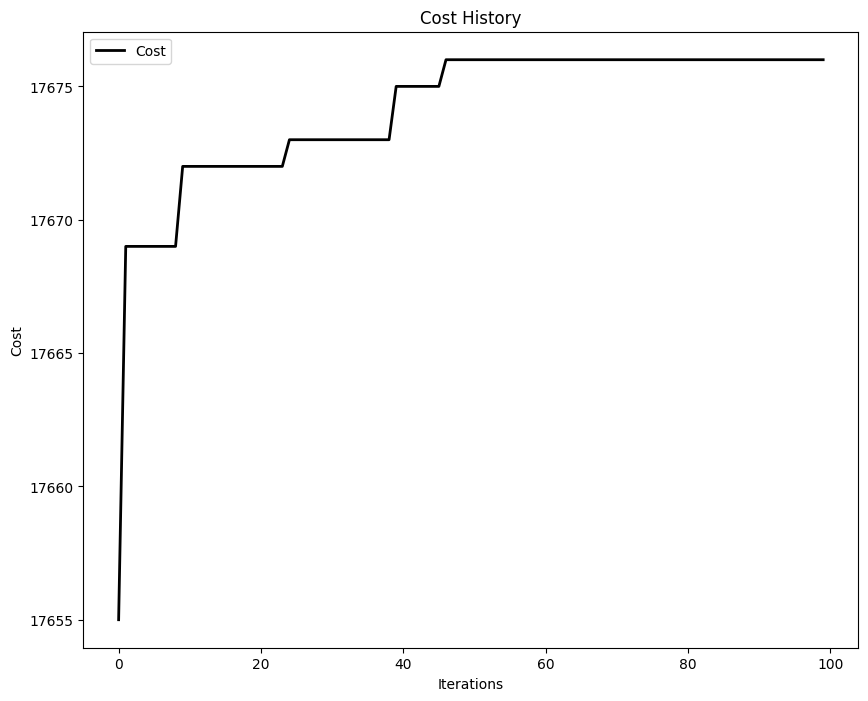

In [12]:
resultPSO.SaveResult(result)

In [13]:
#Que cantidad de particular necesito para correr el PSO:
import math 
decisionVariableArray = constraint_file['variable_splits']
n_particles =  int(10+2*math.sqrt(len(decisionVariableArray)))
n_particles

16

In [22]:
pso_date = '06.05.2024' #datetime.date.today().strftime("%m.%d.%Y")# 
fileName = base_path + f'Pos Result {pso_date}.csv' 
pos_df = pd.read_csv(fileName).drop('Unnamed: 0', axis = 1) # read the pso result file to get the input weights
inputWeights =np.tile(pos_df.pos.to_numpy(), [n_particles, 1]) # create the input weights parameters

In [18]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum , init_pos=inputWeights)

2024-05-29 20:59:21,875 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Input Weight History 05.29.2024.csv


pyswarms.single.global_best:   0%|          |0/50

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125452.0
client_budget - analytical_spend_latest_period: -549369
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125452.0
client_budget - analytical_spend_latest_period: -549369
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125452.0
client_budget - analytical_spend_latest_period: -549369
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125452.0
client_budget - analytical_spend_latest_period: -549369
--------------Optimized spend isn't the same as what

pyswarms.single.global_best:   2%|▏         |1/50, best_cost=-1.25e+5

yhat: -125452.0
client_budget - analytical_spend_latest_period: -549369
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124040.0
client_budget - analytical_spend_latest_period: -544837
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123767.0
client_budget - analytical_spend_latest_period: -543278
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124998.0
client_budget - analytical_spend_latest_period: -548247
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123878.0
client_budget - analytical_spend_la

pyswarms.single.global_best:   4%|▍         |2/50, best_cost=-1.25e+5

yhat: -124607.0
client_budget - analytical_spend_latest_period: -546372
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123923.0
client_budget - analytical_spend_latest_period: -543675
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124014.0
client_budget - analytical_spend_latest_period: -544316
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124118.0
client_budget - analytical_spend_latest_period: -545661
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124094.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:   6%|▌         |3/50, best_cost=-1.25e+5

yhat: -123816.0
client_budget - analytical_spend_latest_period: -543778
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123785.0
client_budget - analytical_spend_latest_period: -543241
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -125149.0
client_budget - analytical_spend_latest_period: -549022
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124520.0
client_budget - analytical_spend_latest_period: -546076
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123923.0
client_budget - analytical_spend_la

pyswarms.single.global_best:   8%|▊         |4/50, best_cost=-1.25e+5

yhat: -123977.0
client_budget - analytical_spend_latest_period: -544512
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124169.0
client_budget - analytical_spend_latest_period: -544999
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124018.0
client_budget - analytical_spend_latest_period: -544742
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124447.0
client_budget - analytical_spend_latest_period: -546359
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124232.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  10%|█         |5/50, best_cost=-1.25e+5

yhat: -124485.0
client_budget - analytical_spend_latest_period: -546453
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124478.0
client_budget - analytical_spend_latest_period: -546692
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123452.0
client_budget - analytical_spend_latest_period: -542105
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124528.0
client_budget - analytical_spend_latest_period: -546588
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124017.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=-1.25e+5

yhat: -125056.0
client_budget - analytical_spend_latest_period: -548426
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123759.0
client_budget - analytical_spend_latest_period: -543555
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124731.0
client_budget - analytical_spend_latest_period: -547565
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124461.0
client_budget - analytical_spend_latest_period: -546715
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124100.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=-1.25e+5

yhat: -124142.0
client_budget - analytical_spend_latest_period: -544876
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124816.0
client_budget - analytical_spend_latest_period: -547656
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124412.0
client_budget - analytical_spend_latest_period: -546469
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124623.0
client_budget - analytical_spend_latest_period: -546913
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123609.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=-1.25e+5

yhat: -123417.0
client_budget - analytical_spend_latest_period: -541379
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124333.0
client_budget - analytical_spend_latest_period: -545421
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124024.0
client_budget - analytical_spend_latest_period: -544800
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124479.0
client_budget - analytical_spend_latest_period: -546915
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124363.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=-1.25e+5

yhat: -124811.0
client_budget - analytical_spend_latest_period: -547332
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123914.0
client_budget - analytical_spend_latest_period: -544241
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124122.0
client_budget - analytical_spend_latest_period: -544753
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124960.0
client_budget - analytical_spend_latest_period: -547900
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123722.0
client_budget - analytical_spend_l

pyswarms.single.global_best:  20%|██        |10/50, best_cost=-1.25e+5

yhat: -124017.0
client_budget - analytical_spend_latest_period: -545069
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124095.0
client_budget - analytical_spend_latest_period: -544573
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123967.0
client_budget - analytical_spend_latest_period: -544075
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123308.0
client_budget - analytical_spend_latest_period: -541306
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123725.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=-1.25e+5

yhat: -124148.0
client_budget - analytical_spend_latest_period: -544171
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123914.0
client_budget - analytical_spend_latest_period: -543440
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124136.0
client_budget - analytical_spend_latest_period: -545073
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124139.0
client_budget - analytical_spend_latest_period: -544196
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123764.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=-1.25e+5

yhat: -123802.0
client_budget - analytical_spend_latest_period: -543430
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123768.0
client_budget - analytical_spend_latest_period: -542972
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124105.0
client_budget - analytical_spend_latest_period: -545045
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124096.0
client_budget - analytical_spend_latest_period: -544800
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124058.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=-1.25e+5

yhat: -124001.0
client_budget - analytical_spend_latest_period: -543991
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124419.0
client_budget - analytical_spend_latest_period: -545520
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124350.0
client_budget - analytical_spend_latest_period: -546149
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125048.0
client_budget - analytical_spend_latest_period: -548428
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124494.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=-1.25e+5

yhat: -123940.0
client_budget - analytical_spend_latest_period: -544409
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124277.0
client_budget - analytical_spend_latest_period: -545975
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124843.0
client_budget - analytical_spend_latest_period: -547821
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124111.0
client_budget - analytical_spend_latest_period: -544562
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124395.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  30%|███       |15/50, best_cost=-1.25e+5

yhat: -124287.0
client_budget - analytical_spend_latest_period: -545610
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124621.0
client_budget - analytical_spend_latest_period: -547233
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124837.0
client_budget - analytical_spend_latest_period: -548023
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124042.0
client_budget - analytical_spend_latest_period: -544229
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123818.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  32%|███▏      |16/50, best_cost=-1.25e+5

yhat: -124781.0
client_budget - analytical_spend_latest_period: -547745
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123612.0
client_budget - analytical_spend_latest_period: -542050
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123602.0
client_budget - analytical_spend_latest_period: -542146
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -125083.0
client_budget - analytical_spend_latest_period: -548612
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124340.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=-1.25e+5

yhat: -123764.0
client_budget - analytical_spend_latest_period: -542611
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123923.0
client_budget - analytical_spend_latest_period: -544442
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124163.0
client_budget - analytical_spend_latest_period: -544966
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123808.0
client_budget - analytical_spend_latest_period: -543759
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125075.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=-1.25e+5

yhat: -123828.0
client_budget - analytical_spend_latest_period: -543865
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124132.0
client_budget - analytical_spend_latest_period: -545179
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124498.0
client_budget - analytical_spend_latest_period: -546563
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124239.0
client_budget - analytical_spend_latest_period: -545359
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123763.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=-1.25e+5

yhat: -124187.0
client_budget - analytical_spend_latest_period: -545216
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124736.0
client_budget - analytical_spend_latest_period: -547390
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125305.0
client_budget - analytical_spend_latest_period: -548625
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125030.0
client_budget - analytical_spend_latest_period: -547978
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124535.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  40%|████      |20/50, best_cost=-1.25e+5

yhat: -124590.0
client_budget - analytical_spend_latest_period: -547196
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123880.0
client_budget - analytical_spend_latest_period: -542969
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123728.0
client_budget - analytical_spend_latest_period: -542972
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123856.0
client_budget - analytical_spend_latest_period: -543778
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123528.0
client_budget - analytical_spend_l

pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=-1.25e+5

yhat: -123797.0
client_budget - analytical_spend_latest_period: -542327
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124041.0
client_budget - analytical_spend_latest_period: -544251
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124381.0
client_budget - analytical_spend_latest_period: -545928
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124471.0
client_budget - analytical_spend_latest_period: -545891
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124425.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=-1.25e+5

yhat: -124081.0
client_budget - analytical_spend_latest_period: -545063
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124333.0
client_budget - analytical_spend_latest_period: -545906
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124244.0
client_budget - analytical_spend_latest_period: -545682
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124841.0
client_budget - analytical_spend_latest_period: -547625
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123594.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=-1.25e+5

yhat: -125111.0
client_budget - analytical_spend_latest_period: -548714
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124536.0
client_budget - analytical_spend_latest_period: -546894
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124862.0
client_budget - analytical_spend_latest_period: -547947
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123923.0
client_budget - analytical_spend_latest_period: -543651
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124410.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=-1.25e+5

yhat: -123647.0
client_budget - analytical_spend_latest_period: -542757
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123673.0
client_budget - analytical_spend_latest_period: -542681
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123879.0
client_budget - analytical_spend_latest_period: -543534
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124098.0
client_budget - analytical_spend_latest_period: -545285
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123689.0
client_budget - analytical_spend_

pyswarms.single.global_best:  50%|█████     |25/50, best_cost=-1.25e+5

yhat: -124779.0
client_budget - analytical_spend_latest_period: -547303
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123844.0
client_budget - analytical_spend_latest_period: -543873
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124113.0
client_budget - analytical_spend_latest_period: -545066
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124725.0
client_budget - analytical_spend_latest_period: -547241
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124503.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=-1.25e+5

yhat: -123444.0
client_budget - analytical_spend_latest_period: -541050
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124765.0
client_budget - analytical_spend_latest_period: -546970
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124578.0
client_budget - analytical_spend_latest_period: -547105
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123934.0
client_budget - analytical_spend_latest_period: -543299
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123552.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=-1.25e+5

yhat: -124464.0
client_budget - analytical_spend_latest_period: -546088
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124775.0
client_budget - analytical_spend_latest_period: -547693
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123871.0
client_budget - analytical_spend_latest_period: -543806
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123997.0
client_budget - analytical_spend_latest_period: -544089
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124553.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=-1.25e+5

yhat: -124823.0
client_budget - analytical_spend_latest_period: -548216
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124092.0
client_budget - analytical_spend_latest_period: -544664
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124526.0
client_budget - analytical_spend_latest_period: -546148
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124824.0
client_budget - analytical_spend_latest_period: -547906
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123503.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=-1.25e+5

yhat: -124256.0
client_budget - analytical_spend_latest_period: -544821
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123979.0
client_budget - analytical_spend_latest_period: -544968
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124526.0
client_budget - analytical_spend_latest_period: -546924
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123566.0
client_budget - analytical_spend_latest_period: -542808
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124463.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  60%|██████    |30/50, best_cost=-1.25e+5

yhat: -124408.0
client_budget - analytical_spend_latest_period: -546581
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124942.0
client_budget - analytical_spend_latest_period: -547954
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123892.0
client_budget - analytical_spend_latest_period: -543932
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124544.0
client_budget - analytical_spend_latest_period: -546645
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123992.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=-1.25e+5

yhat: -124071.0
client_budget - analytical_spend_latest_period: -544590
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123992.0
client_budget - analytical_spend_latest_period: -543796
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124743.0
client_budget - analytical_spend_latest_period: -547182
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123833.0
client_budget - analytical_spend_latest_period: -542207
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124654.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  64%|██████▍   |32/50, best_cost=-1.25e+5

yhat: -124060.0
client_budget - analytical_spend_latest_period: -544693
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124195.0
client_budget - analytical_spend_latest_period: -545501
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124465.0
client_budget - analytical_spend_latest_period: -546811
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124279.0
client_budget - analytical_spend_latest_period: -545610
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123922.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  66%|██████▌   |33/50, best_cost=-1.25e+5

yhat: -124901.0
client_budget - analytical_spend_latest_period: -548022
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124750.0
client_budget - analytical_spend_latest_period: -547478
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123964.0
client_budget - analytical_spend_latest_period: -543935
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -123711.0
client_budget - analytical_spend_latest_period: -542239
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125184.0
client_budget - analytical_spend_l

pyswarms.single.global_best:  68%|██████▊   |34/50, best_cost=-1.25e+5

yhat: -124054.0
client_budget - analytical_spend_latest_period: -544324
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123564.0
client_budget - analytical_spend_latest_period: -542881
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124346.0
client_budget - analytical_spend_latest_period: -546295
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124555.0
client_budget - analytical_spend_latest_period: -546261
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123946.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  70%|███████   |35/50, best_cost=-1.25e+5

yhat: -124607.0
client_budget - analytical_spend_latest_period: -547192
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124039.0
client_budget - analytical_spend_latest_period: -544566
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124724.0
client_budget - analytical_spend_latest_period: -547561
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124425.0
client_budget - analytical_spend_latest_period: -546821
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124714.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  72%|███████▏  |36/50, best_cost=-1.25e+5

yhat: -123501.0
client_budget - analytical_spend_latest_period: -541271
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124926.0
client_budget - analytical_spend_latest_period: -547993
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123942.0
client_budget - analytical_spend_latest_period: -543300
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124047.0
client_budget - analytical_spend_latest_period: -544556
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123746.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=-1.25e+5

yhat: -124170.0
client_budget - analytical_spend_latest_period: -545259
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123585.0
client_budget - analytical_spend_latest_period: -542450
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124175.0
client_budget - analytical_spend_latest_period: -545341
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124630.0
client_budget - analytical_spend_latest_period: -547198
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124500.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=-1.25e+5

yhat: -123711.0
client_budget - analytical_spend_latest_period: -542804
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124458.0
client_budget - analytical_spend_latest_period: -546027
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124478.0
client_budget - analytical_spend_latest_period: -546190
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123862.0
client_budget - analytical_spend_latest_period: -543833
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124025.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=-1.25e+5

yhat: -124282.0
client_budget - analytical_spend_latest_period: -545256
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124610.0
client_budget - analytical_spend_latest_period: -547592
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124876.0
client_budget - analytical_spend_latest_period: -548312
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124334.0
client_budget - analytical_spend_latest_period: -545646
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124293.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  80%|████████  |40/50, best_cost=-1.25e+5

yhat: -124683.0
client_budget - analytical_spend_latest_period: -547275
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123916.0
client_budget - analytical_spend_latest_period: -544170
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123686.0
client_budget - analytical_spend_latest_period: -542560
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124670.0
client_budget - analytical_spend_latest_period: -546953
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123971.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=-1.25e+5

yhat: -124032.0
client_budget - analytical_spend_latest_period: -544278
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124497.0
client_budget - analytical_spend_latest_period: -546065
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124076.0
client_budget - analytical_spend_latest_period: -545208
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123714.0
client_budget - analytical_spend_latest_period: -542922
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124337.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=-1.25e+5

yhat: -124332.0
client_budget - analytical_spend_latest_period: -545696
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124976.0
client_budget - analytical_spend_latest_period: -548414
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125070.0
client_budget - analytical_spend_latest_period: -548504
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124211.0
client_budget - analytical_spend_latest_period: -545480
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123841.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=-1.25e+5

yhat: -123706.0
client_budget - analytical_spend_latest_period: -542668
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124045.0
client_budget - analytical_spend_latest_period: -544633
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123446.0
client_budget - analytical_spend_latest_period: -541522
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123890.0
client_budget - analytical_spend_latest_period: -543408
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124964.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=-1.25e+5

yhat: -123866.0
client_budget - analytical_spend_latest_period: -544242
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124968.0
client_budget - analytical_spend_latest_period: -547907
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124182.0
client_budget - analytical_spend_latest_period: -544872
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124217.0
client_budget - analytical_spend_latest_period: -545546
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124257.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=-1.25e+5

yhat: -124650.0
client_budget - analytical_spend_latest_period: -546555
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123633.0
client_budget - analytical_spend_latest_period: -542720
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -125017.0
client_budget - analytical_spend_latest_period: -548157
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124670.0
client_budget - analytical_spend_latest_period: -546942
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124676.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=-1.25e+5

yhat: -123583.0
client_budget - analytical_spend_latest_period: -542763
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124489.0
client_budget - analytical_spend_latest_period: -546333
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123830.0
client_budget - analytical_spend_latest_period: -543315
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124269.0
client_budget - analytical_spend_latest_period: -544655
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123892.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=-1.25e+5

yhat: -124384.0
client_budget - analytical_spend_latest_period: -546105
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124878.0
client_budget - analytical_spend_latest_period: -547957
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124354.0
client_budget - analytical_spend_latest_period: -545263
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124392.0
client_budget - analytical_spend_latest_period: -546097
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124832.0
client_budget - analytical_spend_la

pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=-1.25e+5

yhat: -123850.0
client_budget - analytical_spend_latest_period: -542676
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123907.0
client_budget - analytical_spend_latest_period: -543943
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124614.0
client_budget - analytical_spend_latest_period: -547461
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123920.0
client_budget - analytical_spend_latest_period: -544024
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124098.0
client_budget - analytical_spend_lat

pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=-1.25e+5

yhat: -124058.0
client_budget - analytical_spend_latest_period: -545285
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: -124419.0
client_budget - analytical_spend_latest_period: -546264
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -123773.0
client_budget - analytical_spend_latest_period: -543587
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124676.0
client_budget - analytical_spend_latest_period: -547009
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: -124315.0
client_budget - analytical_spend_la

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-1.25e+5
2024-05-29 21:25:57,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -125452.0, best pos: [0.98966289 1.05837595 1.15002284 1.16319901 1.02812998 1.1759372
 1.12248407 0.76651048 0.80727459]


yhat: -123750.0
client_budget - analytical_spend_latest_period: -542808
Compute duration: 1595.9189558029175


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Pos Result 05.29.2024.csv
File exists. Please delete it first.
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Iteration History 05.29.2024.csv
File exists. Please delete it first.


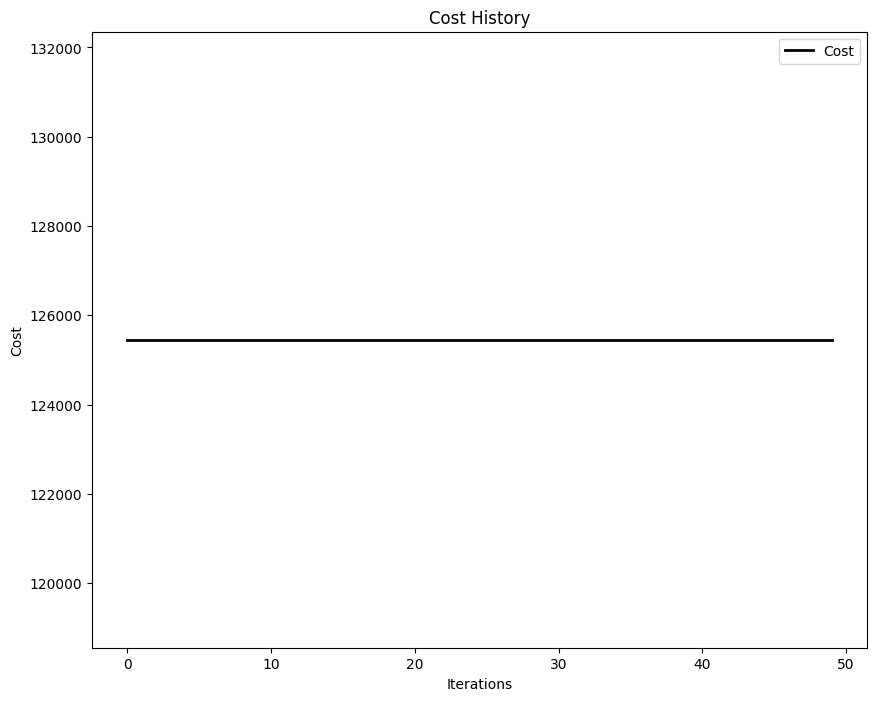

In [19]:
resultPSO.SaveResult(result)

In [8]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)

In [10]:
itNum = 100 #entre 100 a 150 cuando se tiene mas iteraciones
n_particles = 0 #asi dentro de la columna me calcula el número de particulas optima
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}

In [11]:
result = resultPSO.run_pso(options, n_partic les=n_particles, itNum = itNum)

2024-05-29 19:15:08,068 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/Input Weight History 05.29.2024.csv


pyswarms.single.global_best:   0%|          |0/100

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
Multiple NaN matched yhat found for:

      market account_type     funnel         ds           X  yhat
3911  Mexico            -  Non_Brand 2024-04-25   39.085235   NaN
3912  Mexico            -  Non_Brand 2024-04-25   70.527790   NaN
3913  Mexico            -  Non_Brand 2024-04-26   42.029082   NaN
3914  Mexico            -  Non_Brand 2024-04-26   94.055924   NaN
3915  Mexico            -  Non_Brand 2024-04-27   10.269498   NaN
...      ...          ...        ...        ...         ...   ...
4495  Mexico            -  Non_Brand 2024-12-30   91.441506   NaN
4496  Mexico            -  Non_Brand 2024-12-31    0.438334   NaN
4497  Mexico            -  Non_Brand 2024-12-31   12.248989   NaN
4498  Mexico            -  Non_Brand 2024-12-31   56.220342   NaN
4499  Mexico            -  Non_Brand 2024-12-31  170.357539   NaN

[58

pyswarms.single.global_best:   0%|          |0/100

Multiple NaN matched yhat found for:

      market account_type     funnel         ds           X  yhat
3911  Mexico            -  Non_Brand 2024-04-25   39.085235   NaN
3912  Mexico            -  Non_Brand 2024-04-25   70.527790   NaN
3913  Mexico            -  Non_Brand 2024-04-26   42.029082   NaN
3914  Mexico            -  Non_Brand 2024-04-26   94.055924   NaN
3915  Mexico            -  Non_Brand 2024-04-27   10.269498   NaN
...      ...          ...        ...        ...         ...   ...
4495  Mexico            -  Non_Brand 2024-12-30   91.441506   NaN
4496  Mexico            -  Non_Brand 2024-12-31    0.438334   NaN
4497  Mexico            -  Non_Brand 2024-12-31   12.248989   NaN
4498  Mexico            -  Non_Brand 2024-12-31   56.220342   NaN
4499  Mexico            -  Non_Brand 2024-12-31  170.357539   NaN

[589 rows x 6 columns]


UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.Float64DType'>) -> None

In [ ]:
resultPSO.SaveResult(result)